# Brain Tumor Classification
In this project we will try to classify if the given image has any of the 4 types of brain tumor or not using a deep learning technique known as transfer learning.
Transfer Learning refers to the use of already trained models on a new related problems. The model used in this notebook is known as efficientnet_v2 by Google.


In [101]:
# import essential libraries
import tensorflow as tf
import cv2
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import pathlib 
import PIL.Image as Image
import tensorflow_hub as hub

from sklearn.metrics import classification_report
from tensorflow import keras

In [29]:
# get the data
train_data_location = "/kaggle/input/brain-tumor-classification-mri/Training"
test_data_location = "/kaggle/input/brain-tumor-classification-mri/Testing"

In [30]:
train_data = pathlib.Path(train_data_location)
test_data = pathlib.Path(test_data_location)
train_data

PosixPath('/kaggle/input/brain-tumor-classification-mri/Training')

In [24]:
# total number of images 
print('Number of train images: ',len(list(train_data.glob('*/*.jpg'))))
print("Number of test images: ",len(list(test_data.glob('*/*.jpg'))))

Number of train images:  2870
Number of test images:  394


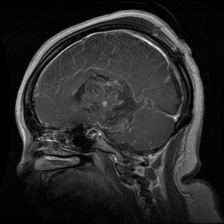

In [39]:
# take a look at a few images
Image.open(str(list(train_data.glob('glioma_tumor/*'))[12])).resize((224,224))

In [38]:
# shape of each image
cv2.imread(str(list(train_data.glob('glioma_tumor/*'))[1])).shape

(512, 512, 3)

In [40]:
# preprocess the data to train the model
IMAGE_SHAPE = (224,224)
def preprocess_data(data): # converts the image data into arrays of desirable shape
    # store the images and labels in two dictionaries
    images_dict = {
        "glioma_tumor" : list(data.glob('glioma_tumor/*')),
        "meningioma_tumor" : list(data.glob('meningioma_tumor/*')),
        "no_tumor" : list(data.glob('no_tumor/*')),
        "pituitary_tumor" : list(data.glob('pituitary_tumor/*'))
    }
    labels_dict = {
        "glioma_tumor" : 0,
        "meningioma_tumor" : 1,
        "no_tumor" : 2,
        "pituitary_tumor" : 3
    }
    X,y = [],[]
    for name,images in images_dict.items():
        for image in images:
            img = cv2.imread(str(image)) # reads image in array form
            resized_img = cv2.resize(img,IMAGE_SHAPE) # resizes the image
            X.append(resized_img) # appends resized image into the image array
            y.append(labels_dict[name]) # appends corresponding label into label array
    return X,y
    


In [41]:
# call the function for test and train data
X_train,y_train = preprocess_data(train_data)
X_test,y_test = preprocess_data(test_data)

In [46]:
# convert into numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
# now the data is almost ready

In [56]:
# import the efficientnet_v2 model
base_model_location = "/kaggle/input/efficientnet-v2/tensorflow2/imagenet1k-b0-classification/2"
model_hub = hub.KerasLayer(base_model_location,input_shape=(224,224,3),trainable=False)

In [69]:
# build the model 
# add an output layer to the efficientnet_v2 model
model2 = keras.Sequential([
    model_hub, # base_model
    # output layer of the base model
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4,activation='softmax')
])
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 1000)              7200312   
                                                                 
 dense_12 (Dense)            (None, 128)               128128    
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 4)                 260       
                                                                 
Total params: 7336956 (27.99 MB)
Trainable params: 136

In [70]:
# rescale the train and test data
X_train_scaled = X_train/255.0
X_test_scaled = X_test/255.0

# compile the model
model2.compile(optimizer='adam',
             loss = 'sparse_categorical_crossentropy',
             metrics=['accuracy'])
# train the model 
model2.fit(X_train_scaled,y_train,epochs=20)

Epoch 1/20
90/90 [==============================] - 6s 33ms/step - loss: 0.9718 - accuracy: 0.5986
Epoch 2/20
90/90 [==============================] - 3s 33ms/step - loss: 0.5834 - accuracy: 0.7756
Epoch 3/20
90/90 [==============================] - 3s 33ms/step - loss: 0.5058 - accuracy: 0.7997
Epoch 4/20
90/90 [==============================] - 3s 33ms/step - loss: 0.4567 - accuracy: 0.8334
Epoch 5/20
90/90 [==============================] - 3s 32ms/step - loss: 0.4052 - accuracy: 0.8436
Epoch 6/20
90/90 [==============================] - 3s 33ms/step - loss: 0.3958 - accuracy: 0.8505
Epoch 7/20
90/90 [==============================] - 3s 33ms/step - loss: 0.3624 - accuracy: 0.8592
Epoch 8/20
90/90 [==============================] - 3s 33ms/step - loss: 0.3257 - accuracy: 0.8798
Epoch 9/20
90/90 [==============================] - 3s 33ms/step - loss: 0.3116 - accuracy: 0.8784
Epoch 10/20
90/90 [==============================] - 3s 32ms/step - loss: 0.2915 - accuracy: 0.8944
Epoch 11/

In [87]:
# evaluate the model on test data
print("Test Loss: ",model2.evaluate(X_test_scaled,y_test)[0])
print("Test Accuracy: ",model2.evaluate(X_test_scaled,y_test)[1])

13/13 [==============================] - 0s 32ms/step - loss: 2.0811 - accuracy: 0.7107
Test Loss:  2.081097364425659
13/13 [==============================] - 0s 31ms/step - loss: 2.0811 - accuracy: 0.7107
Test Accuracy:  0.710659921169281


In [72]:
# add a data augmentation layer to increase the accuracy
data_augmentation = keras.Sequential([
    keras.layers.experimental.preprocessing.RandomFlip('horizontal',
                                                       input_shape=(224,224,3)),
    keras.layers.experimental.preprocessing.RandomRotation(0.1),
    keras.layers.experimental.preprocessing.RandomZoom(0.1),
    keras.layers.experimental.preprocessing.RandomContrast(0.2)
])

In [84]:
model5 = keras.Sequential([
    data_augmentation,
    model_hub,
    keras.layers.Dense(128,activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4,activation='softmax')
])
model5.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_3 (KerasLayer)  (None, 1000)              7200312   
                                                                 
 dense_25 (Dense)            (None, 128)               128128    
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 4)                 516       
                                                                 
Total params: 7328956 (27.96 MB)
Trainable params: 128644 (502.52 KB)
Non-trainable params: 7200312 (27.47 MB)
_________________________________________________________________


In [85]:
model5.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model5.fit(X_train_scaled,y_train,epochs=15)

Epoch 1/15
90/90 [==============================] - 6s 37ms/step - loss: 0.8020 - accuracy: 0.6850
Epoch 2/15
90/90 [==============================] - 3s 37ms/step - loss: 0.5447 - accuracy: 0.7836
Epoch 3/15
90/90 [==============================] - 3s 36ms/step - loss: 0.4843 - accuracy: 0.8118
Epoch 4/15
90/90 [==============================] - 3s 37ms/step - loss: 0.4455 - accuracy: 0.8355
Epoch 5/15
90/90 [==============================] - 3s 37ms/step - loss: 0.4392 - accuracy: 0.8362
Epoch 6/15
90/90 [==============================] - 3s 37ms/step - loss: 0.3949 - accuracy: 0.8467
Epoch 7/15
90/90 [==============================] - 3s 37ms/step - loss: 0.3705 - accuracy: 0.8589
Epoch 8/15
90/90 [==============================] - 3s 37ms/step - loss: 0.3622 - accuracy: 0.8592
Epoch 9/15
90/90 [==============================] - 3s 36ms/step - loss: 0.3628 - accuracy: 0.8526
Epoch 10/15
90/90 [==============================] - 3s 36ms/step - loss: 0.3545 - accuracy: 0.8638
Epoch 11/

In [88]:
x = model5.evaluate(X_test_scaled,y_test)
print("Test Accuracy: ",x[1])
print("Test Loss: ",x[0])

13/13 [==============================] - 0s 30ms/step - loss: 1.2889 - accuracy: 0.6904
Test Accuracy:  0.6903553009033203
Test Loss:  1.288896918296814


In [97]:
# the reason for such a low accuracy might be the size of the training data
# deep learning models work best on large datasets
y_pred = model2.predict(X_test_scaled)
y_preds = [np.argmax(i) for i in y_pred]


13/13 [==============================] - 0s 29ms/step


[1, 1]

In [102]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       1.00      0.21      0.35       100
           1       0.58      0.99      0.74       115
           2       0.76      0.96      0.85       105
           3       0.98      0.59      0.74        74

    accuracy                           0.71       394
   macro avg       0.83      0.69      0.67       394
weighted avg       0.81      0.71      0.67       394

